### 12.1

In [7]:
# I am going to work through some of the exercise and solutions to generate the variables I need for these exercises. 

from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [9]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [10]:
def GroupByDay(transactions, func=np.mean):

    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

In [16]:
def GroupByQualityAndDay(transactions):

    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

dailies = GroupByQualityAndDay(transactions)

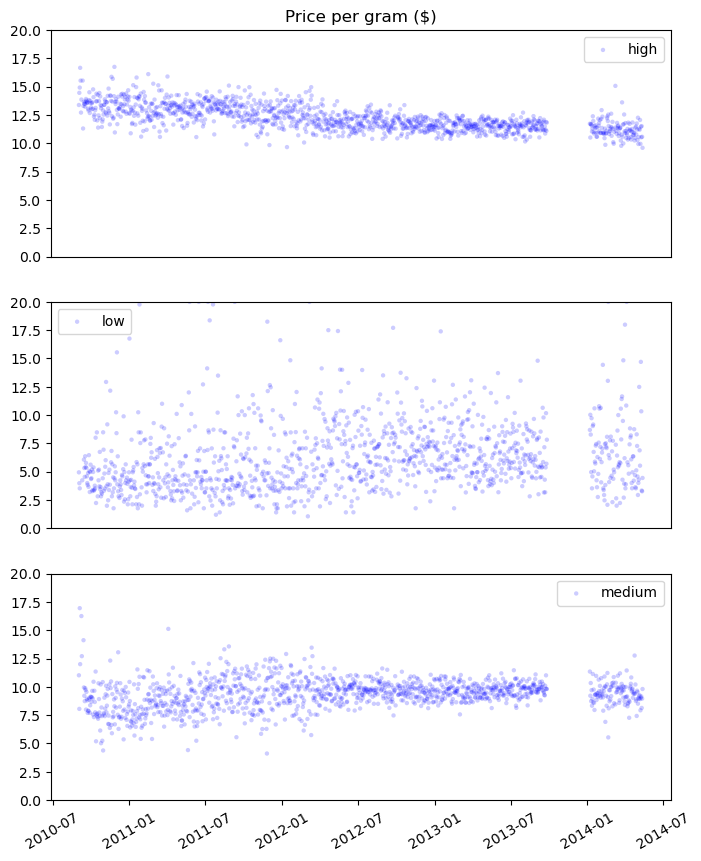

In [17]:
import matplotlib.pyplot as plt

thinkplot.PrePlot(rows=3)
for i, (name, daily) in enumerate(dailies.items()):
    thinkplot.SubPlot(i+1)
    title = 'Price per gram ($)' if i == 0 else ''
    thinkplot.Config(ylim=[0, 20], title=title)
    thinkplot.Scatter(daily.ppg, s=10, label=name)
    if i == 2: 
        plt.xticks(rotation=30)
        thinkplot.Config()
    else:
        thinkplot.Config(xticks=[])

In [20]:
def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

In [23]:
def PlotFittedValues(model, results, label=""):

    years = model.exog[:, 1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label="model", color="#ff7f00")

### Solution starts here

In [25]:
# The goal here is to convert the linear model to quadratic

# First we need to duplicate the RunQuadraticModel fuction
import statsmodels.formula.api as smf

def RunQuadraticModel(daily):

    daily["years2"] = daily.years**2
    model = smf.ols("ppg ~ years + years2", data=daily)
    results = model.fit()
    return model, results


In [26]:
from IPython.display import display

name = "high"
daily = dailies[name]

model, results = RunQuadraticModel(daily)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sun, 19 Feb 2023   Prob (F-statistic):          4.57e-164
Time:                        20:28:40   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

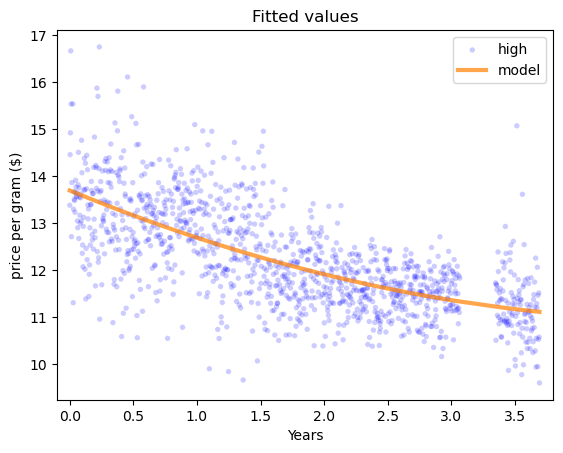

In [27]:
PlotFittedValues(model, results, label=name)
thinkplot.Config(
    title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8], ylabel="price per gram ($)"
)

In [49]:
def PlotPredictions(daily, years, iters=101, percent=90, func=RunLinearModel):

    result_seq = SimulateResults(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100 - p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="gray")

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="gray")

In [51]:
def SimulateResults(daily, iters=101, func=RunLinearModel):
    _, results = func(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = func(fake)
        result_seq.append(fake_results)

    return result_seq

In [53]:
def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)

    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq

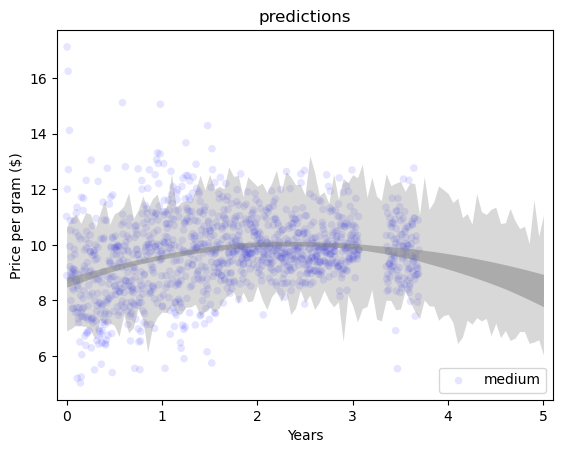

In [54]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years, func=RunQuadraticModel)
thinkplot.Config(
    title="predictions",
    xlabel="Years",
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",
)

In [28]:
array = np.arange(10)

In [29]:
series = pd.Series(array)
series.rolling(3).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

In [30]:
def PlotRollingMean(daily, name):

    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = pd.Series(reindexed.ppg).rolling(30).mean()
    thinkplot.Plot(roll_mean, label="rolling mean", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="price per gram ($)")

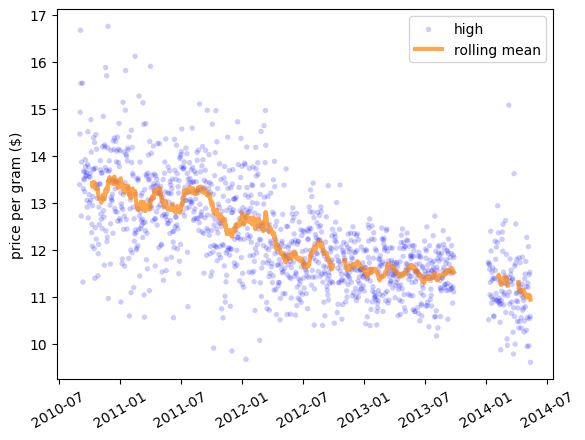

In [31]:
PlotRollingMean(daily, name)

In [32]:
def PlotEWMA(daily, name):

    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = reindexed.ppg.ewm(30).mean()
    thinkplot.Plot(roll_mean, label="EWMA", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="price per gram ($)")

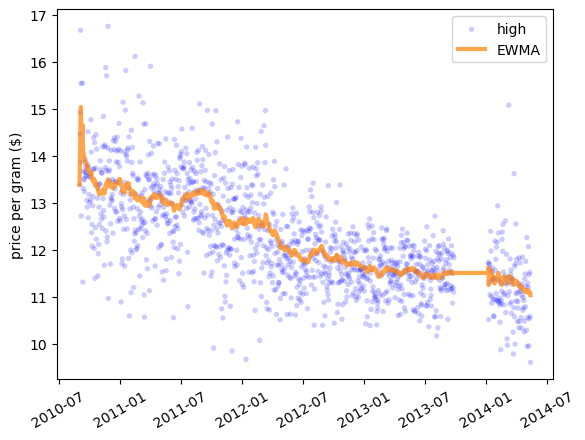

In [33]:
PlotEWMA(daily, name)

In [34]:
def FillMissing(daily, span=30):

    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pd.Series(reindexed.ppg).ewm(span=span).mean()

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed["ewma"] = ewma
    reindexed["resid"] = reindexed.ppg - ewma
    return reindexed

In [35]:
def PlotFilled(daily, name):

    filled = FillMissing(daily, span=30)
    thinkplot.Scatter(filled.ppg, s=15, alpha=0.2, label=name)
    thinkplot.Plot(filled.ewma, label="EWMA", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="Price per gram ($)")

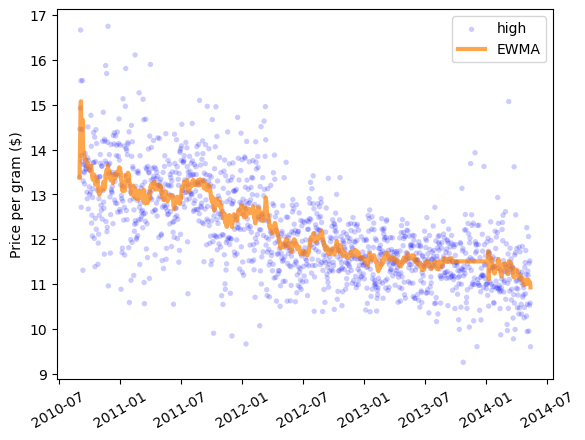

In [36]:
PlotFilled(daily, name)

### 12.2 Solution and Chapter Practice

In [55]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        series, lag = data
        test_stat = abs(SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

In [56]:
name = "high"
daily = dailies[name]

series = daily.ppg
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.42703525999862774 0.0


In [57]:
_, results = RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.0827995862585425 0.001


In [58]:
_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
pvalue = test.PValue()
print(test.actual, pvalue)

0.06899192423447484 0.008


In [38]:

filled_dailies = {}
for name, daily in dailies.items():
    filled_dailies[name] = FillMissing(daily, span=30)

In [37]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [39]:
for name, filled in filled_dailies.items():
    corr = thinkstats2.SerialCorr(filled.ppg, lag=1)
    print(name, corr)

high 0.4938293284419145
low 0.12452920178552189
medium 0.19735656849716834


In [40]:
for name, filled in filled_dailies.items():
    corr = thinkstats2.SerialCorr(filled.resid, lag=1)
    print(name, corr)

high -0.004916975561202729
low 0.05374696001158652
medium -0.009391342157377879


In [41]:
rows = []
for lag in [1, 7, 30, 365]:
    print(lag, end="\t")
    for name, filled in filled_dailies.items():
        corr = SerialCorr(filled.resid, lag)
        print("%.2g" % corr, end="\t")
    print()

1	-0.0049	0.054	-0.0094	
7	-0.0012	-0.028	-0.036	
30	0.0012	-0.023	-0.0028	
365	0.066	0.033	0.013	


In [42]:
import statsmodels.tsa.stattools as smtsa

filled = filled_dailies["high"]
acf = smtsa.acf(filled.resid, nlags=365, adjusted=True, fft=False)
print("%0.2g, %.2g, %0.2g, %0.2g, %0.2g" % (acf[0], acf[1], acf[7], acf[30], acf[365]))

1, -0.0049, -0.0012, 0.0012, 0.065


In [43]:
def SimulateAutocorrelation(daily, iters=1001, nlags=40):

    # run simulations
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, adjusted=True, fft=False)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags + 1)
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color="gray")

In [44]:
def PlotAutoCorrelation(dailies, nlags=40, add_weekly=False):

    thinkplot.PrePlot(3)
    daily = dailies["high"]
    SimulateAutocorrelation(daily)

    for name, daily in dailies.items():

        if add_weekly:
            daily.ppg = AddWeeklySeasonality(daily)

        filled = FillMissing(daily, span=30)

        acf = smtsa.acf(filled.resid, nlags=nlags, adjusted=True, fft=False)
        lags = np.arange(len(acf))
        thinkplot.Plot(lags[1:], acf[1:], label=name)

In [45]:
def AddWeeklySeasonality(daily):

    fri_or_sat = (daily.index.dayofweek == 4) | (daily.index.dayofweek == 5)
    fake = daily.ppg.copy()
    fake[fri_or_sat] += np.random.uniform(0, 2, fri_or_sat.sum())
    return fake

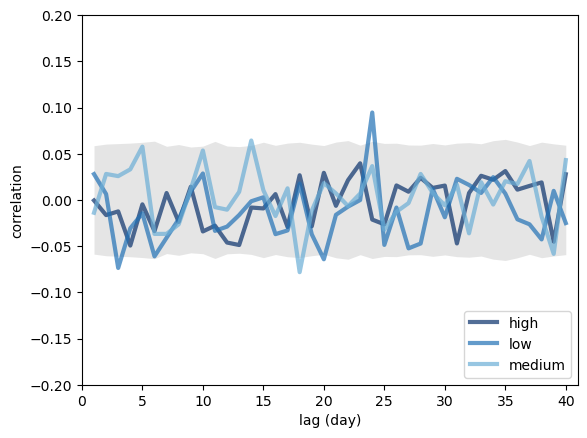

In [46]:
axis = [0, 41, -0.2, 0.2]

PlotAutoCorrelation(dailies, add_weekly=False)
thinkplot.Config(axis=axis, loc="lower right", ylabel="correlation", xlabel="lag (day)")

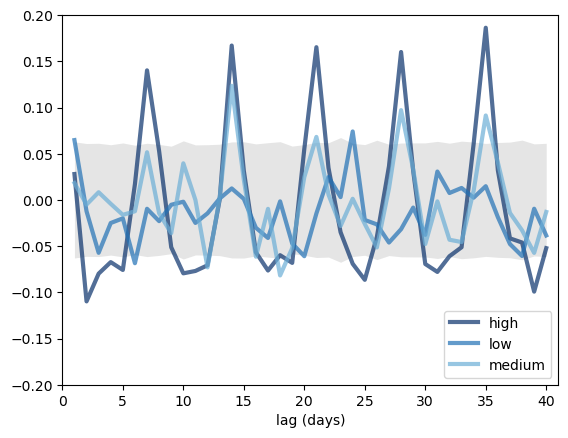

In [47]:
PlotAutoCorrelation(dailies, add_weekly=True)
thinkplot.Config(axis=axis, loc="lower right", xlabel="lag (days)")